In [1]:
!git clone https://github.com/nam157/ai4theblind.git

Cloning into 'ai4theblind'...
remote: Enumerating objects: 272, done.
remote: Counting objects: 100% (272/272), done.
remote: Compressing objects: 100% (256/256), done.
remote: Total 272 (delta 103), reused 83 (delta 6), pack-reused 0
Receiving objects: 100% (272/272), 77.99 MiB | 30.35 MiB/s, done.
Resolving deltas: 100% (103/103), done.


In [12]:
import sys
sys.path.insert(0,'/content/ai4theblind/object_detection/Mobilenetv1-SSD/')
import models.config_mobilenetv1 as config
from models.mobilenet_model import create_mobilenetv1_ssd
from data_loader.data_preprocessing import PredictionTransform
import utils.box_utils_ver2 as box_utils
import torch,cv2

In [13]:
class_names = ['BACKGROUND','aeroplane', 'bicycle', 'bird', 'boat',
                'bottle', 'bus', 'car', 'cat', 'chair',
                'cow', 'diningtable', 'dog', 'horse',
                'motorbike', 'person', 'pottedplant',
                'sheep', 'sofa', 'train', 'tvmonitor']

### Gặp lỗi về Nms

In [26]:
#Inference
##1. decode
##2. Nms (Non-maximun_supression) (Khá là khó hiểu)
##3. Predict
class Predictor:
  def __init__(self,net,img_size,mean = 0.0,std = 1.0,nms_method=None,
                 iou_threshold=0.45, filter_threshold=0.01, candidate_size=200, sigma=0.5, device=None):
        self.net = net
        self.size = img_size
        self.nms_method = nms_method
        self.iou_threshold = iou_threshold
        self.candidate_size = candidate_size
        self.sigma = sigma
        self.transform = PredictionTransform(img_size, mean, std)
        if device:
          self.device = device
        else:
          self.device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
        self.net.to(self.device)
        self.net.eval()
  def predict(self,image,top_k = -1,prob_threshold =  None):
        """
        *Image: Input 
        *Top_k: mỗi object thì chúng ta lấy k boxes dựa vào conf
        *prob_threshold: ao nhiêu phần trăm trùng nhau (overlap)

        *Thực hiện decode và nms

        """

        cpu_device = torch.device("cpu")
        height, width, _ = image.shape
        image = self.transform(image)
        images = image.unsqueeze(0)
        images = images.to(self.device)

        with torch.no_grad():
                scores, boxes = self.net.forward(images)        
        boxes = boxes[0]
        scores = scores[0]
        if not prob_threshold:
            prob_threshold = self.filter_threshold
       
        #Di chuyển vào CPU
        boxes = boxes.to(cpu_device)
        scores = scores.to(cpu_device)
        picked_box_probs = []
        picked_labels = []
        for class_index in range(1, scores.size(1)):
            probs = scores[:, class_index]
            mask = probs > prob_threshold
            probs = probs[mask]
            if probs.size(0) == 0:
                continue
            subset_boxes = boxes[mask, :]
            box_probs = torch.cat([subset_boxes, probs.reshape(-1, 1)], dim=1)
            box_probs = box_utils.nms(box_probs, self.nms_method,
                                      score_threshold=prob_threshold,
                                      iou_threshold=self.iou_threshold,
                                      sigma=self.sigma,
                                      top_k=top_k,
                                      candidate_size=self.candidate_size)
            picked_box_probs.append(box_probs)
            picked_labels.extend([class_index] * box_probs.size(0))
        if not picked_box_probs:
            return torch.tensor([]), torch.tensor([]), torch.tensor([])
        picked_box_probs = torch.cat(picked_box_probs)
        picked_box_probs[:, 0] *= width
        picked_box_probs[:, 1] *= height
        picked_box_probs[:, 2] *= width
        picked_box_probs[:, 3] *= height
        return picked_box_probs[:, :4], torch.tensor(picked_labels), picked_box_probs[:, 4]


In [56]:
def create_mobilenetv1_ssd_predictor(net, candidate_size=200, nms_method=None, sigma=0.5, device=None):
    predictor = Predictor(net, config.image_size, config.image_mean,
                          config.image_std,
                          nms_method=nms_method,
                          iou_threshold=config.iou_threshold,
                          candidate_size=candidate_size,
                          sigma=sigma,
                          device=device)
    return predictor

In [57]:
#Load model-weight
net = create_mobilenetv1_ssd(num_classes=21)
model_path = "/content/mobilenet-v1-ssd-mp-0_675.pth"
net.load(model_path)
#Load predictor
predictor = create_mobilenetv1_ssd_predictor(net, candidate_size=200)

In [62]:
image_path = "/content/test.jpg"
orig_image = cv2.imread(image_path)
image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
boxes, labels, probs = predictor.predict(image, 10, 0.7)

Inference time:  0.09094524383544922


In [63]:
len(labels),len(boxes)

(155, 155)

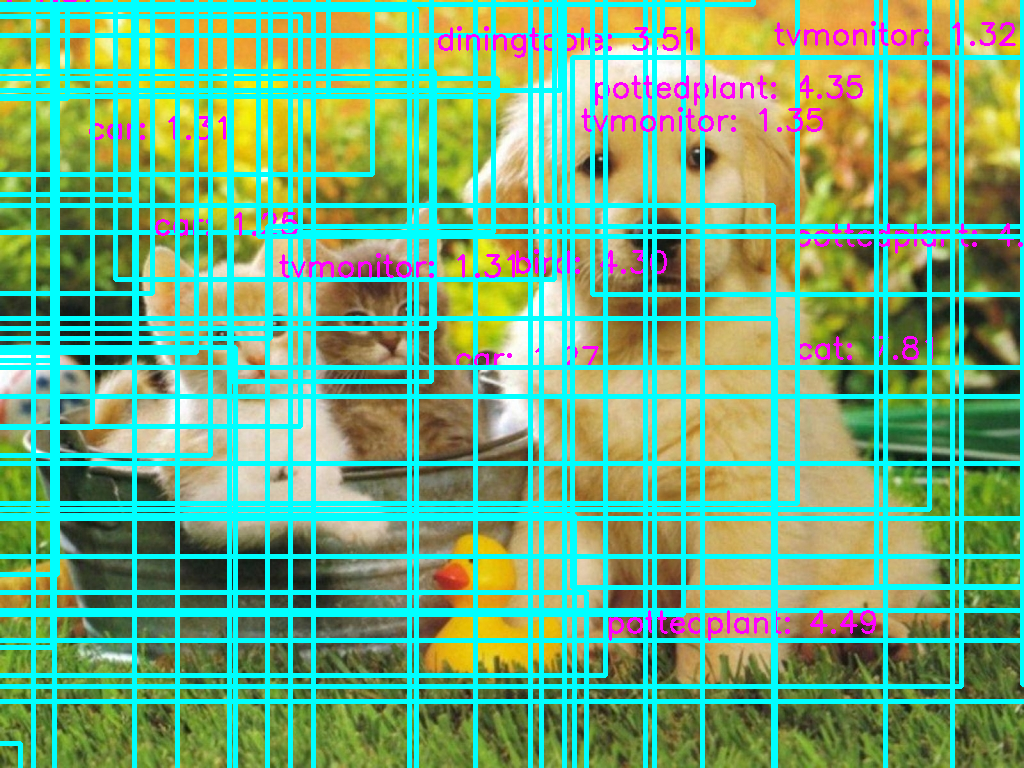

True

In [64]:
from google.colab.patches import cv2_imshow
for i in range(boxes.size(0)):
    box = boxes[i, :]
    cv2.rectangle(orig_image, (box[0], box[1]), (box[2], box[3]), (255, 255, 0), 4)
    label = f"{class_names[labels[i]]}: {probs[i]:.2f}"
    cv2.putText(orig_image, label,(box[0] + 20, box[1] + 40),cv2.FONT_HERSHEY_SIMPLEX,1,(255, 0, 255),2)
cv2_imshow(orig_image)
path = "run_ssd_example_output.jpg"
cv2.imwrite(path, orig_image)